<a href="https://colab.research.google.com/github/VincentCsNv/SymbioseManagement/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!pip install rasterio laspy lazrs --quiet
#!pip install pdal --quiet
!pip install torch torchvision --quiet
!pip install scikit-learn --quiet
!pip install tqdm --quiet
!pip install torchsummary --quiet


In [153]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import laspy
from pathlib import Path
import glob 
import pandas as pd
import lib.functions_utils as fu
import lib.models as models
import torch
import sklearn
from torch.utils.data import DataLoader
from torchsummary import summary


from importlib import reload
reload(fu)
reload(models)

<module 'lib.models' from '/Users/Vincent/Documents/2025/Projets_pro/Symbiose Management/SymbioseManagement/lib/models.py'>

In [92]:
DATA_dir = "data_light/"
repartition = { 'train': 0.8, 'val': 0.1, 'test': 0.1}
random_seed = 42

# I. Data :

## A. Collect data in dataframes:

In [93]:
#Getting data information in a dataframe
data_df = fu.extrating_data_to_df(DATA_dir, repartition = repartition, random_seed = random_seed, new_rep = True)
#fu.detailed_distribution(data_df[data_df["type"] == "imagery"]) #Visualization 


Getting all the files .tiff and .laz path...
Number of files : 244


## B. DataLoader Creation :

In [124]:
batch_size = 2
input_type = 'imagery'  # 'imagery' or 'lidar'
transform = None  # Add any data augmentation or preprocessing transforms if needed

In [135]:
train_dataloader = fu.create_dataloader( df=data_df[data_df["dataset"]=="train"],  batch_size=batch_size, input_type=input_type, transform=transform)
val_dataloader = fu.create_dataloader( df=data_df[data_df["dataset"]=="val"],  batch_size=batch_size, input_type=input_type, transform=transform)

#test
inputs, labels = next(iter(train_dataloader))
print(f'Input batch shape: {inputs.shape}')
print(f'Label batch shape: {labels.shape}')

Input batch shape: torch.Size([2, 4, 128, 128])
Label batch shape: torch.Size([2])


# II. Model training : 

In [140]:
model = models.convnet(nb_class=train_dataloader.dataset.num_classes)
summary(model, input_size=(4,128,128))  # Exclude batch size for input_size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             592
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Linear-13                  [-1, 256]       2,097,408
          Dropout-14                  [

In [144]:
results = models.train(model,train_dataloader,val_dataloader,
             epochs=3, 
             max_lr=0.001, 
             loss_func = torch.nn.CrossEntropyLoss(),
             optim = "Adam")

training in progress:  33%|███▎      | 1/3 [00:08<00:17,  8.51s/it]

Number of epochs: 1 | Validation loss : 0.6340073943138123  | Training loss : 0.6959946155548096  |   Training accuracy: 0.5 validation accuracy : 0.8333333134651184


training in progress:  67%|██████▋   | 2/3 [00:14<00:06,  6.92s/it]

Number of epochs: 2 | Validation loss : 0.5561723113059998  | Training loss : 0.5992929339408875  |   Training accuracy: 0.5 validation accuracy : 0.6666666865348816


training in progress: 100%|██████████| 3/3 [00:20<00:00,  6.92s/it]

Number of epochs: 3 | Validation loss : 0.5062160491943359  | Training loss : 0.5228444933891296  |   Training accuracy: 1.0 validation accuracy : 0.5833333134651184


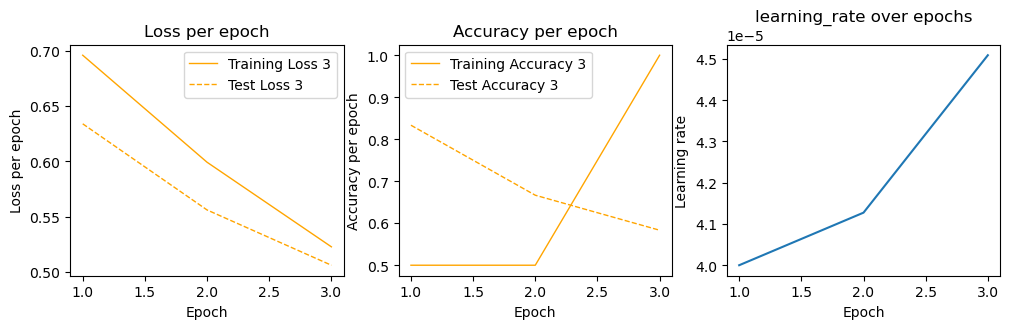

In [154]:


#Getting and plot metrics
plt.figure(figsize=(12,3))
epoch = 3
tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count = fu.getting_metrics(results,epoch)
fu.plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,epoch)


# III. Evaluate the model:

In [ ]:

#Functions :
def eval_test(model_eval,testloader,OPTION_eval = "A",GPU =False,all_info =False):
  model_eval.eval()
  batch_losses, batch_accs=[],[]
  all_predictions, all_labels = [], []  # Pour la matrice de confusion
  i=0

  for images,labels in testloader:
    labels = convert_labels(labels,eq_df,old_label="label",new_label=f"label_{OPTION_eval}",GPU=GPU)
    predicted=model_eval(images)
    batch_losses.append(loss_func(predicted,labels))
    if OPTION_eval == "A":
      batch_accs.append(accuracy(predicted,labels,GPU=GPU))
    elif OPTION_eval == "B":
      batch_accs.append(accuracy_B(predicted,labels,GPU=GPU))

    # Collecter pour matrice de confusion
    _, preds = torch.max(predicted, 1)  # Classes prédites
    if OPTION_eval =="B":
      preds = convert_labels(preds,eq_df,old_label="label_B",new_label="label_A",GPU=GPU)
      labels = convert_labels(labels,eq_df,old_label="label_B",new_label="label_A",GPU=GPU)
    all_predictions.extend(preds.cpu().numpy())#all_predictions.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy()) #   all_labels.extend(labels.cpu().numpy())
  if all_info:
    print(classification_report(all_labels, all_predictions))
  #print accuracy
  print(f"Accuracy {OPTION_eval}: {accuracy_score(all_labels, all_predictions)}")
  return all_predictions, all_labels
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(cm,SUPER_CLASSES,all_info = False,label=""):
  # Plot de la matrice de confusion
  class_names = SUPER_CLASSES
  #plt.figure(figsize=(4, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names,yticklabels=class_names)
  plt.title(f'Matrice de Confusion {label}')
  plt.ylabel('Vraies labels')
  plt.xlabel('Prédictions')

  def predict_img(img,model,mode = "A",GPU="false"):
  model.eval()
  img = img.unsqueeze(0)
  if GPU:
    img = move_device(img, device)
  yb = model(img)
  _, pred = torch.max(yb, dim=1)
  if mode == "A":
    pred = pred.item()
  elif mode == "B":
    pred = convert_labels(pred,eq_df,old_label="label_B",new_label="label_A",GPU = GPU)
    pred = pred.item()
  return pred

def predict_and_show(img,label,model,mode = "A",GPU = "False"):
  pred = predict_img(img,model,mode=mode,GPU=GPU)
  #Getting Super Class name from ground truth and prediction
  pred_sc = eq_df[eq_df[f"label_{mode}"]==pred]["superclass"].values[0]
  label_sc = eq_df[eq_df["label"]==label]["superclass"].values[0]
  if GPU:
    img = img.cpu()
  img=img*0.5 +0.5 #Denormalize the img
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"gt: {label_sc}, pred :{pred_sc} ")
  return pred

torch.Size([2, 4, 250, 250])

In [ ]:
#PARAMETERS and CKP option A
OPTION_eval = "A"
MODEL_eval = "conv"
PATH_CKP = '/content/model_A_optim_Adam_best_epoch_weights.pth'

print("Evaluation of model A")
model_eval_A = set_model(MODEL_eval,OPTION_eval,SUPER_CLASSES,train_df,GPU=GPU,FROM_CKP = True,CKP_PATH = PATH_CKP)
all_predictions_A, all_labels_A = eval_test(model_eval_A,testloader,OPTION_eval=OPTION_eval)
cm_A =   confusion_matrix(all_labels_A, all_predictions_A)

#PARAMETERS and CKP option B
OPTION_eval = "B"
MODEL_eval = "conv"
PATH_CKP = '/content/model_B_optim_Adam_best_epoch_weights.pth'

print("Evaluation of model B")
model_eval_B = set_model(MODEL_eval,OPTION_eval,SUPER_CLASSES,train_df,GPU=GPU,FROM_CKP = True,CKP_PATH = PATH_CKP)
all_predictions_B, all_labels_B = eval_test(model_eval_B,testloader,OPTION_eval=OPTION_eval)
cm_B =   confusion_matrix(all_labels_B, all_predictions_B)


In [ ]:
plt.figure(figsize=(12,6))
#Option A
plt.subplot(1,2,1)
plot_confusion_matrix(cm_A,SUPER_CLASSES,label="A")
#Option B
plt.subplot(1,2,2)
plot_confusion_matrix(cm_B,SUPER_CLASSES,label ="B")